# Facial Recognition with Different Feature Extractions
Project Mentor: Darius Irani

Team Members: Ruixin Li (<rli57@jh.edu>), Kejia Ren (<kren6@jh.edu>), Longji Yin (<lyin10@jh.edu>), Zhongyuan Zheng (<zzheng34@jh.edu>)

Link to Git repo: <https://github.com/charlierkj/Facial-Recognition>

# Descriptions

Our project is about investigating different feature extraction methods (e.g. PCA, LDA, ICA, LBP, HoG), including dimensionality reductions and visual descriptors, on human face recognition task, verifying their advances and better understanding their properties by experiment with several simple classifiers (e.g. k-NN and SVM). And further, we compare their performances with a deep neural net baseline (ResNet18), to show the effectiveness of appropriate feature extractions for the task.

# Outline and Deliverables

### Completed Deliverables:

**Must accomplish**

  1.  Successfully load the image data from datasets to workspace, split the datasets to train/test sets, ie. implement the data loader.(in "**Dataset**" below)
  2.  Analyze the statistics of the data and visualize the distribution of data features and labels.(in "**Dataset**" below)
  3.  Apply PCA and LDA methods to do the feature extraction on image data.(in "**Feature Extractions**" below)
  4.  Train Support Vector Machine as the classifier on the training set, conduct hyperparameter sweep and test the classification resulton test image set.(in "**Classifiers**" below)
    
**Expect to accomplish**

  1.  Try ICA and LBP methods to do the feature extraction on image data.(in "**Feature Extractions**" below)
  2.  Try HoG method to do the feature extraction on image data.(in "**Feature Extractions**" below)
  3.  Train k-NN as the classifier on the training set, test the classification result on test image set.(in "**Classifiers**" below)
    
**Would like to accomplish**

  1.  Use advanced convolutional neural network, e.g. ResNet, to learn global and local features for classification.(in "**Classifiers**" below)
  2.  Compare the test accuracy using different feature extraction methods and classifiers combinations.(in "**Results**" below)
  3.  Evaluate the models using the comparison result and analyze the best method for this image analysis problem.(in "**Results**" below)

# Preliminaries

## Problem we are trying to solve and understand

Human facial recoginition is a very useful application that can be used in real world for purpose of license identification, public surveillance, etc. Briefly speaking, the task we are going to solve is a multi-class classification problem. Specifically, given a (grayscale) human face image, we would like to predict the subject (class) the face is belonging to. This is very similar to many other multi-class image classification problems as introduced in class.

However, compared to other image classification problems, object classification for example, facial recognition could be more challenging since different human faces share very similar features and have large intra-class variations like illuminations, viewpoints, etc. Therefore, applying more representative feature extractions is important to help improve the performance of classifiers, which is what we are going to investigate in this project.


## Importing related modules

Basically, we uses packages from Scikit-learn (<https://scikit-learn.org/stable/>), scikit-image (<https://scikit-image.org/docs/dev/api/skimage.html>) and PyTorch (<https://pytorch.org/>). Besides, we will also use our customized codes for better managing the whole project and more efficiently training and loading models.

To run the notebook demo with our customized codes, please clone our provided Git repo (<https://github.com/charlierkj/Facial-Recognition>), and copy this notebook under the cloned directory on your local machine for use.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch.utils.data as td

In [2]:
from dataset import ExtendedYaleFace
from features import *
from classifiers import *
from utils import *

## Dataset

We use the cropped version of Extended Yale Face Database B (<http://vision.ucsd.edu/~leekc/ExtYaleDatabase/ExtYaleB.html>), which contains 2414 centered grayscale images of 38 subjects, under 9 poses and 64 illumination conditions. The original resolution of the image is 192 (height) x 168 (width).

To access this dataset, please navigate to the link provided above and click "Cropped Images" to download the cropped version of the dataset. And then please create a folder called "data" locally under our project Git directory. Finally, please extract the downloaded dataset into your newly created "/data" folder for use.

Here we visualize the original image of the first data in the dataset to get some sense about what the images look like.

Original image shape is (192, 168)


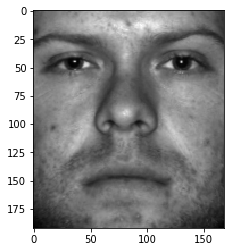

In [3]:
img = Image.open('data/CroppedYale/yaleB01/yaleB01_P00A+000E+00.pgm')
img = np.array(img)
print("Original image shape is", img.shape)
plt.imshow(img, cmap='gray')
plt.show()

## Pre-processing

For convenience, we implemented a dataset class called ExtendedYaleFace derived from the type torch.utils.data.Dataset, where we pre-process the data by 1) downsizing the images to 32 x 32 resolution; 2) normalizing the pixel value to [-1, 1] to make it zero-mean; 3) randomly spliting 80% data to be train samples and the rest 20% to be test samples. 

We downsize the image in order to make the information more compact. After downsizing, the images will have a lower resolution which is more computationally efficient and easier to interpretate, and at the same time, the images still keep much of the original structure which is sufficient for the classifiers/models to make good predictions.

For normalization, we want to convert the originally categorical pixel features/values to approximately continuous, and also to make it zero-mean, since we believe it would potentially make the optmization in training more efficient, especially for the deep neural net. Therefore, we normalize our image data to [-1, 1].

Furthermore, we also provide options whether to flatten the pixel features or not. In other words, we can either choose to keep the spatial structure of the image with unchanged resolution 32 x 32, or choose to flatten the image into a 1024-dim vector. The former should be used when extracting visual descriptors since it requires such spatial structure on 2D images, and the latter should be used when applying dimensionality reductions with PCA, etc.

To note, we do not apply any data augmentations or pre-training since we want to make a fair comparision for different feature extractions. We do not care very much about how accurate it can potentially achieve by applying many tricky techniques, what we are more interested is how different feature extractions or classifiers will perform given only limited samples in the original dataset.

Here we visualize some data in the train set after pre-processing, and also print out some basic information related to our pre-processing (e.g. number of samples in train/test set, image resolution, etc)

Total number of images in train set is 1931
Total number of images in test set is 483
Dimension of the batch data is torch.Size([4, 1, 32, 32])
Batch size is 4
Channel is 1
Image shape is resized to: torch.Size([32, 32])


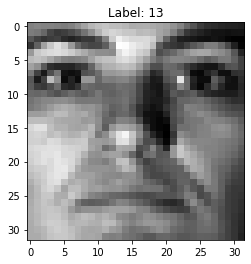

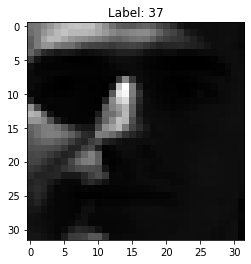

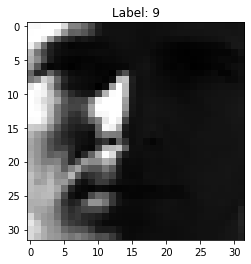

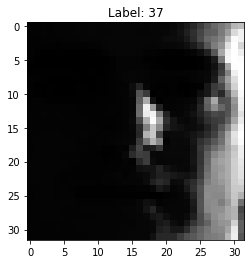

In [4]:
# dataset (unflattened, normalized to [-1, 1])
train_set = ExtendedYaleFace(root="data/CroppedYale", image_shape=[32, 32], flatten=False, normalize=True, train=True)
test_set = ExtendedYaleFace(root="data/CroppedYale", image_shape=[32, 32], flatten=False, normalize=True, test=True)
print("Total number of images in train set is", train_set.__len__())
print("Total number of images in test set is", test_set.__len__())

# dataloader
train_loader = td.DataLoader(train_set, batch_size=4, shuffle=False)
test_loader = td.DataLoader(test_set, batch_size=4, shuffle=False)

# visualize the first batch
for batch_idx, (image_batch, labels) in enumerate(train_loader):
    if batch_idx >= 1:
        break
    print("Dimension of the batch data is", image_batch.shape)
    print("Batch size is", image_batch.shape[0])
    print("Channel is", image_batch.shape[1])
    print("Image shape is resized to:", image_batch.shape[2:])
    for img_idx, img in enumerate(image_batch):
        plt.title("Label: %d" % labels[img_idx])
        plt.imshow(img.squeeze(0), cmap='gray')
        plt.show()

To note, we apply a random seed for spliting the train/test set to guarantee its consistency across different experiment runs. And below are plots to visualize the class balance in our train/test set. By visualizing the frequency of data across different classes, we can confirm that there is no severe class imbalance in the train and test set. Therefore, we do not need further processing to deal with the class imbalance problem.

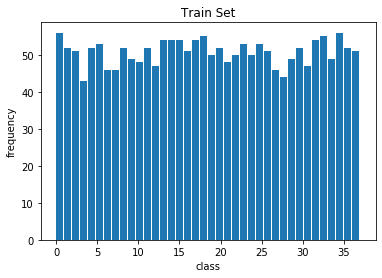

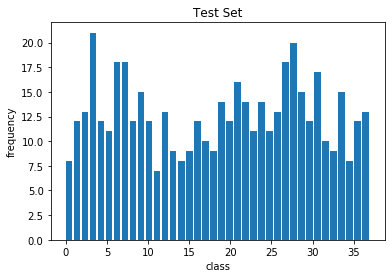

In [5]:
plt.hist(train_set.labels, bins=38, density=False, width=0.8)
plt.title("Train Set")
plt.xlabel("class")
plt.ylabel("frequency")
plt.show()

_, y_test = next(iter(test_loader))
plt.hist(test_set.labels, bins=38, density=False, width=0.8)
plt.title("Test Set")
plt.xlabel("class")
plt.ylabel("frequency")
plt.show()

# Methods and Evaluation

## Experimental Setup

We will test combinations of different feature extractions (PCA, ICA, LDA, LBP, and HoG) and different simple classifiers (k-NN and SVM) to get ideas about effectiveness of different methods. We will evaluate the performance of different methods by its accuracy (recognition rate) on this classification task. Furthermore, we also train a deep neural net based on ResNet18 architecture for our task, since we are also curious about how a deep neural net can perform on this task and we expect to reveal whether suitable feature extractions can help much simpler classifiers outperform the more complex deep neural net.

The loss function for SVM is hinge loss, and the loss function for training deep neural net (ResNet18) is cross entropy loss. There is no loss required for fitting k-NN since it simply memorizes all training samples and makes predictions on unseen data by comparing its similarity with all training samples.

## Baseline

Since we are most interested in how different feature extraction methods will help improve the classifications, we select our basaeline as no feature extraction applied (that is using all pixels on the image as features). And we expect to see, after applying feature extractions, we can achieve higher accuracy with less number of features.

## Methods

Since the methods we use are from two aspects: 1) several feature extraction methods; 2) several classifier models, we will separately introduce them in the following sections

### 1). Feature Extractions

In general, we will use five feature extraction methods, including Principle Component Analysis (PCA), Independent Component Analysis (ICA), Linear Discriminant Analysis (LDA), Local Binary Pattern (LBP), and Histogram of Gradient (HoG). 

Briefly speaking, the basic ideas of PCA, ICA and LDA are similar, they are going to find some projections that best separate the training data into assigned classes, and they are usually also treated as dimonsionality reduction techniques. One big difference among them is that PCA and ICA are unsupervised (no labels are needed when fitting) but LDA is a supervised method.

LBP and HoG are both visual descriptors, they are going to find some local representations that can best describe the spatial structure of the images and invariant to variations like intensity, scale, etc.

We choose these five methods because we find they are frequently used and effective in many image classification tasks (e.g. facial recognition, object classification, texture classification) based on our investigation on relevant literature. And they are also easy to implement and apply.

And to evaluate them, besides the final accuracy on test data, we will also plot the t-SNE visualization after feature extractions. Even though t-SNE is not sufficient to make any conclusions on the effectiveness of different methods, it can give us some initial sense of how different methods can potentially perform. Most of the time, if the data after applying some feature extraction is well separated in the t-SNE visualization, this feature extractor is likely to give a good performance at the end.

In [6]:
# used to store different extracted features.
X_train = {}
y_train = train_set.labels
X_test = {}
y_test = test_set.labels

In [7]:
# dataset (flattened, normalized to [-1, 1])
train_set_flat = ExtendedYaleFace(root="data/CroppedYale", image_shape=[32, 32], flatten=True, normalize=True, train=True)
test_set_flat = ExtendedYaleFace(root="data/CroppedYale", image_shape=[32, 32], flatten=True, normalize=True, test=True)

#### a). Principle Component Analysis (PCA)

The idea behind this method is trying to find the Principle Component (basis) of the training dataset which indicates the 
projections with the largest variance. It can help us drastically decrease the number of features while keep the accuracy at a high level.

Dimension of the batch data is torch.Size([1931, 1, 1024])
Model saved to models/pca.pkl.


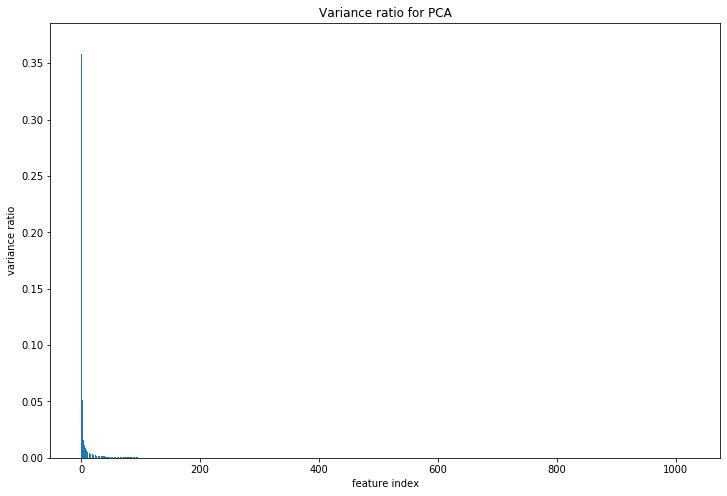

In [8]:
# fit PCA
pca = pca_fit(train_set_flat)
save_model(pca, "models/pca.pkl")
    
# plot variance ratio
plt.figure(figsize=(12, 8))
plt.title("Variance ratio for PCA")
plt.bar(np.arange(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.xlabel("feature index")
plt.ylabel("variance ratio")
plt.show()

**How to determine the number of basis we need?**

We plot the the calculmated variance with respect to the number of selected components.

From the figure below, we can easily draw that when we choose the top 50 components, it alreay covers 95% variance for the whole dataset that can cover sufficiently much information of the image.

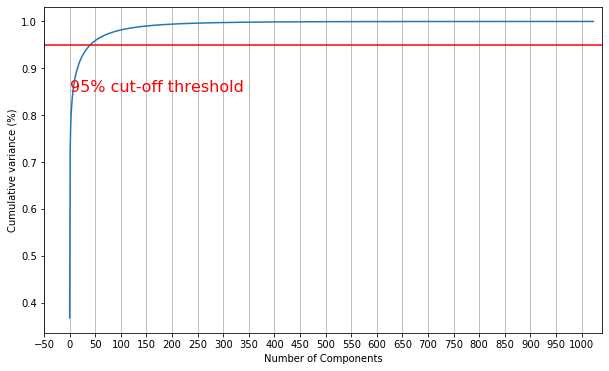

In [9]:
# Plot cumulative variance figure
plt.figure(figsize=(10,6))

cumulated_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(np.arange(len(pca.explained_variance_ratio_)),cumulated_variance)
plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)
plt.grid(axis='x')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative variance (%)')
plt.xlim(-50, 1040)
locs, _ = plt.xticks(np.arange(-50,1050,50 ))

And we show the top 10 components (eigenfaces) below for visualization.

Dimension of the batch data is torch.Size([1931, 1, 1024])
Dimension of the batch data is torch.Size([483, 1, 1024])


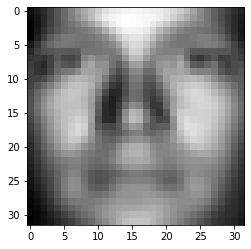

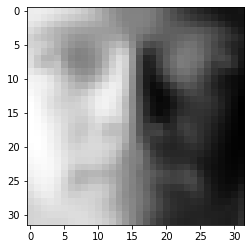

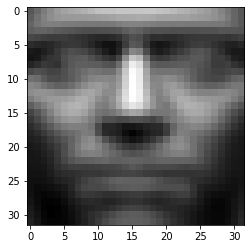

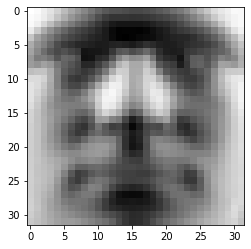

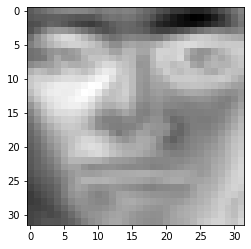

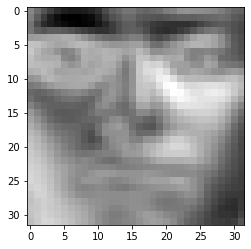

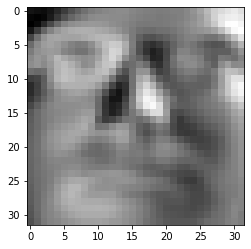

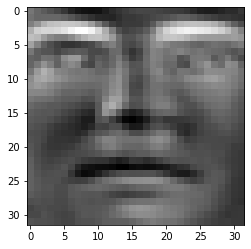

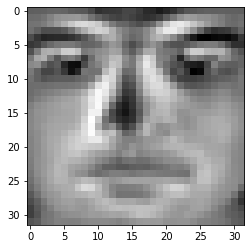

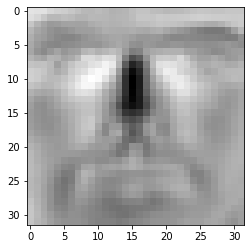

In [10]:
# store features
X_train['pca'] = pca_transform(pca, train_set_flat)[:, 0:50]
X_test['pca'] = pca_transform(pca, test_set_flat)[:, 0:50]

eigenfaces = pca.components_.reshape(-1, 32, 32)

for i in range(10):
    plt.imshow(eigenfaces[i], cmap='gray')
    plt.show()

We then further verify that our selected 50 components can cover sufficient information, by reconstructing the face image with these components.

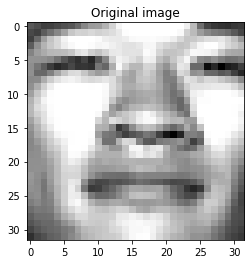

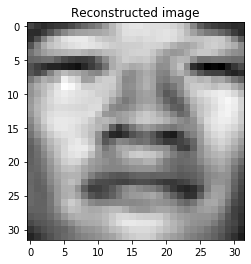

In [11]:
# original image
imgs, _ = next(iter(test_loader))
img_original = imgs[0]
plt.title("Original image")
plt.imshow(img_original.squeeze().numpy().reshape(32, 32), cmap='gray')
plt.show()

# reconstructed image
img_reconstructed = pca.mean_.reshape(32, 32)
for i in range(X_test['pca'].shape[1]):
    img_reconstructed += X_test['pca'][0, i] * eigenfaces[i]
plt.title("Reconstructed image")
plt.imshow(img_reconstructed, cmap='gray')
plt.show()

Below is the t-SNE visualization plot for train set after PCA dimensionality reduction.

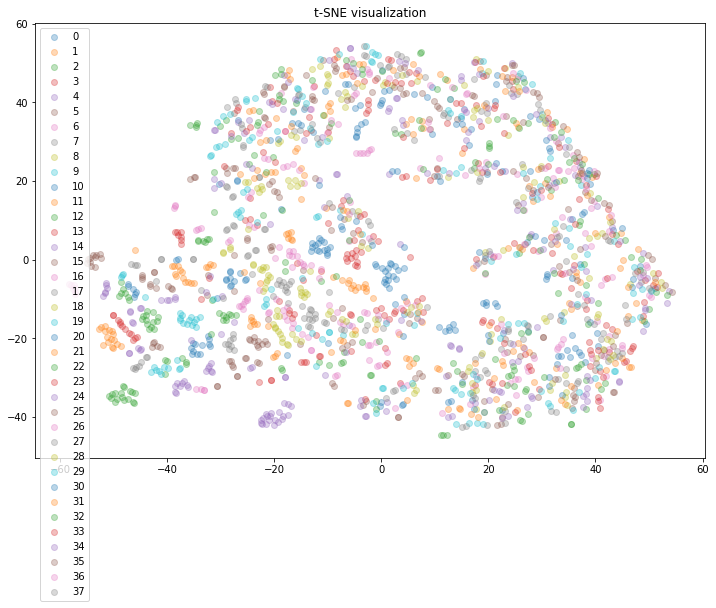

In [12]:
visualize_tsne(X_train['pca'], y_train)

#### b). Linear Discriminant Analysis (LDA)

LDA is closely related to PCA that it also seeks for linear combination of components to best explain the data. However, unlike PCA, LDA will takes into account the difference between classes and explicitly model this difference, and thus it needs labels when fitting and is a supervised method.

Similar with PCA, the hyperparameter for this method is the number of components we decide to keep. And also similar with PCA, thsi component selection can be done by a variance analysis, we keep the minimum number of components that can cover sufficiently much information of the original data.

In [13]:
# fit LDA
lda = lda_fit(train_set_flat, 30)
save_model(lda, "models/lda.pkl")
    
# store features
X_train['lda'] = lda_transform(lda, train_set_flat)
X_test['lda'] = lda_transform(lda, test_set_flat)

Dimension of the batch data is torch.Size([1931, 1, 1024])
Model saved to models/lda.pkl.
Dimension of the batch data is torch.Size([1931, 1, 1024])
Dimension of the batch data is torch.Size([483, 1, 1024])


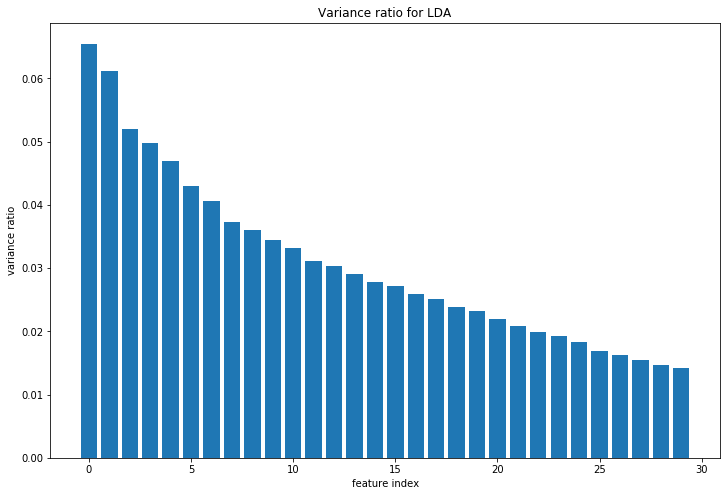

In [14]:
# plot variance ratio for LDA
plt.figure(figsize=(12, 8))
plt.title("Variance ratio for LDA")
plt.bar(np.arange(len(lda.explained_variance_ratio_)), lda.explained_variance_ratio_)
plt.xlabel("feature index")
plt.ylabel("variance ratio")
plt.show()

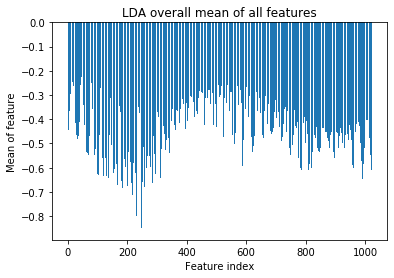

In [15]:
# plot overall features mean
plt.bar(np.arange(len(lda.xbar_)), height = lda.xbar_, width=0.8)
plt.title("LDA overall mean of all features")
plt.xlabel("Feature index")
plt.ylabel("Mean of feature")
plt.show()

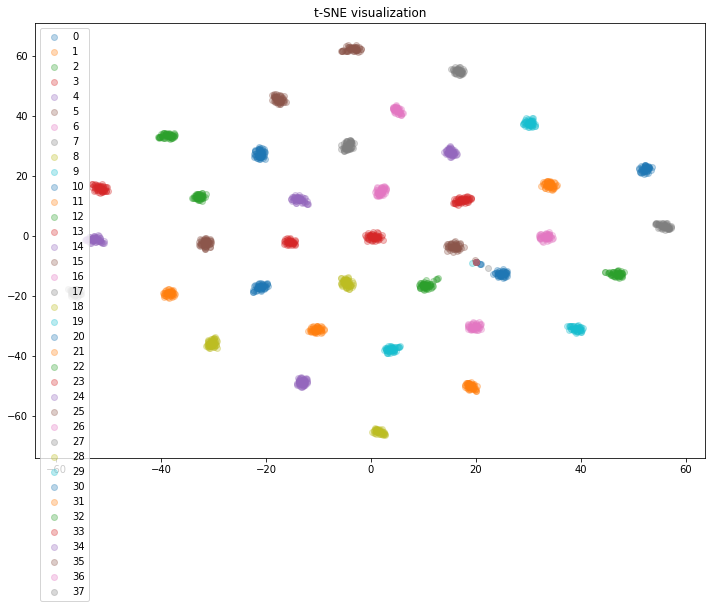

In [16]:
# visualize t-SNE
visualize_tsne(X_train['lda'], y_train)

#### c). Independent Component Analysis (ICA)

ICA is quite similar as PCA, however, it will not only care about removing the correlations (as what PCA does), but will also remove some higher order dependency between different features.

In [17]:
# fit ICA
ica, _ = ica_fit(train_set_flat)
save_model(ica, "models/ica.pkl")

Dimension of the batch data is torch.Size([1931, 1, 1024])
Model saved to models/ica.pkl.


**How to choose the hyperparameters?**

The only hyperparameter we need to care about is the number of basis we need same as PCA, however, instead of just plot the
calculmated variance figure like PCA, we choose different set for this hyperparameter, and use a simple SVM to train and test the accuracy.

The result figure can been seen as below:

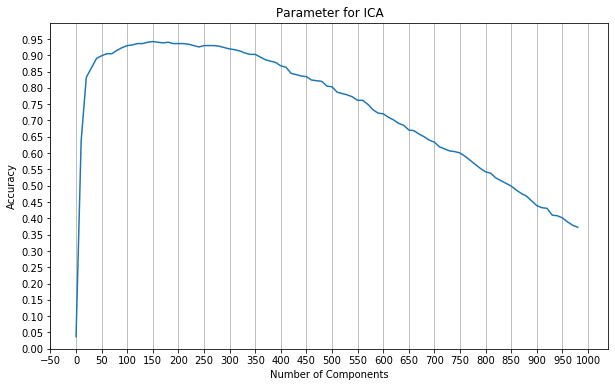

In [18]:
import pandas as pd

df = pd.read_csv('time.csv')
plt.figure(figsize=(10,6))
plt.plot(np.arange(len(df['accuracy']))*10, df['accuracy'])
plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.xlim(-50, 1040)
plt.ylim(0.0, 1)
plt.grid(axis='x')
locs, _ = plt.xticks(np.arange(-50,1050,50 ))
locs, _ = plt.yticks(np.arange(0.0, 1, 0.05 ))
plt.title('Parameter for ICA')
plt.show()

From the aboe figure, we can easily draw that when we choose the basis between 50-200, we get the highest accuracy,
and for the best accuracy, we choose 150 basis for this case.

Just for curiosity, we plot the first 10 components obtained by ICA. Compared to PCA, the faces from ICA basis is not that natural.

Dimension of the batch data is torch.Size([1931, 1, 1024])
Dimension of the batch data is torch.Size([483, 1, 1024])


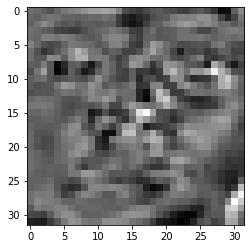

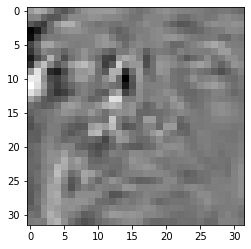

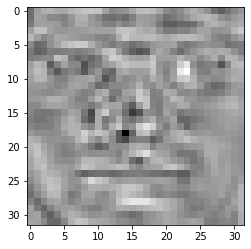

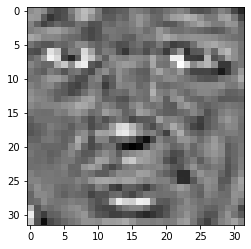

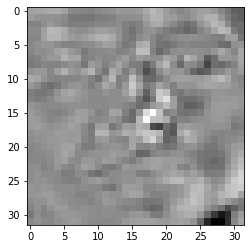

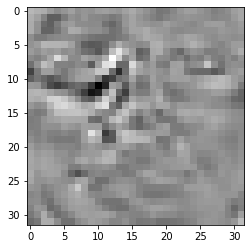

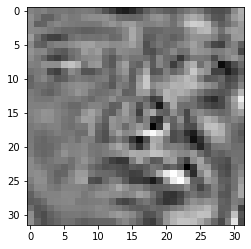

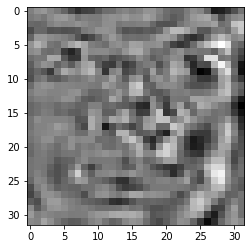

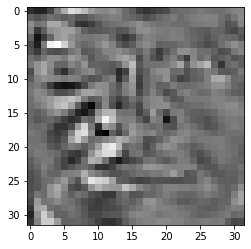

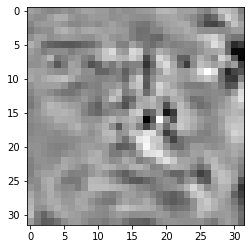

In [19]:
# store features
X_train['ica'] = ica_transform(ica, train_set_flat)
X_test['ica'] = ica_transform(ica, test_set_flat)

basis = ica.components_.reshape(-1, 32, 32)

for i in range(10):
    plt.imshow(basis[i], cmap='gray')
    plt.show()

Below is the visualization of face reconstruction by ICA components.

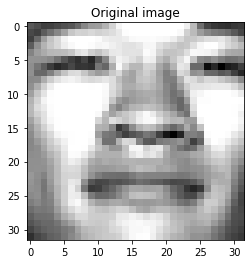

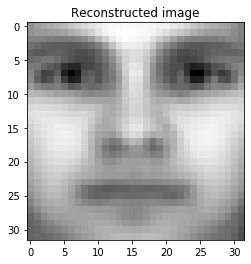

In [20]:
# original image
imgs, _ = next(iter(test_loader))
img_original = imgs[0]
plt.title("Original image")
plt.imshow(img_original.squeeze().numpy().reshape(32, 32), cmap='gray')
plt.show()

# reconstructed image
img_reconstructed = ica.mean_.reshape(32, 32)
for i in range(X_test['ica'].shape[1]):
    img_reconstructed += X_test['ica'][0, i] * basis[i]
plt.title("Reconstructed image")
plt.imshow(img_reconstructed, cmap='gray')
plt.show()

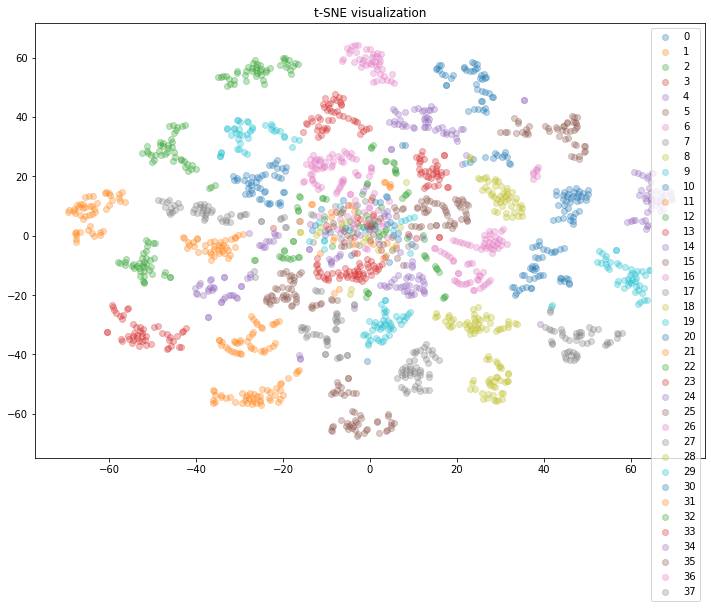

In [21]:
# visualize t-SNE
visualize_tsne(X_train['ica'], y_train)

#### d). Local Binary Pattern (LBP)

Local Binary Pattern (LBP) is a simple yet very efficient texture operator that can be used as rotation-invariance descriptors to reduce the feature lenght. For its basic idea, it labels the pixels of an image by thresholding the neighborhood of each pixel and encodes such local patterns as binary codes. We will use the histogram of binary codes as our features.

In [22]:
# transform
X_train_transformed, X_train_hists = lbp_transform(train_set)
X_test_transformed, X_test_hists = lbp_transform(test_set)

# store features
X_train['lbp'] = X_train_hists
X_test['lbp'] = X_test_hists

Below is the visualization of LBP and the corresponding histogram for the first training data, and the t-SNE visualization of train set after applying LBP features.

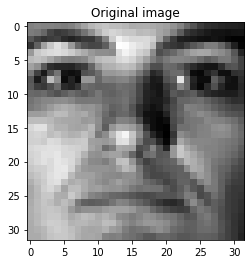

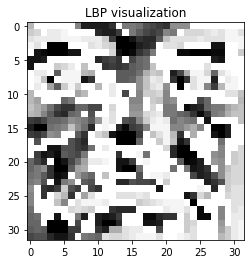

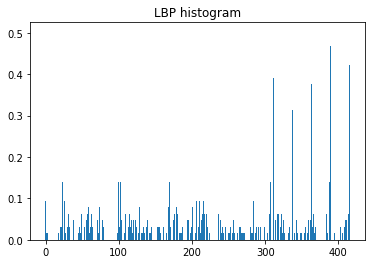

In [23]:
# original image
imgs, _ = next(iter(train_loader))
img_original = imgs[0]
plt.title("Original image")
plt.imshow(img_original.squeeze().numpy(), cmap='gray')
plt.show()

# LBP
plt.title("LBP visualization")
plt.imshow(X_train_transformed[0], cmap='gray')
plt.show()

# histogram
plt.title("LBP histogram")
plt.bar(np.arange(len(X_train_hists[0])), X_train_hists[0], width=0.8)
plt.show()

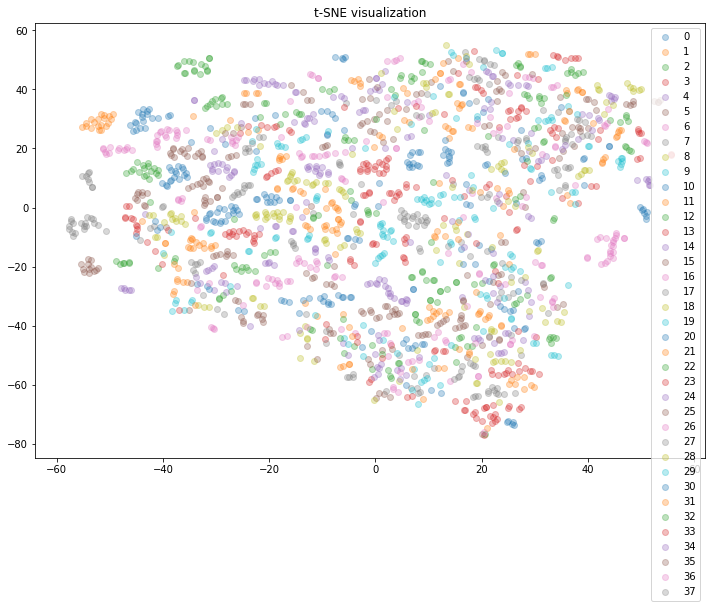

In [24]:
# visualize t-SNE
visualize_tsne(X_train['lbp'], y_train)

#### e). Histogram of Gradient (HoG)

The main idea of HoG is trying to compute the gradient for each pixel along row direction and column direction. Then
based on these values, it calculate the orientation and the norm of the gradients, and creates the histogram for each single cell (group of pixels), which is used as our HoG features.

In [25]:
# transform
hog_train, hog_images_train = hog_transform(train_set)
hog_test, hog_images_test = hog_transform(test_set)

# store features
X_train['hog'] = hog_train
X_test['hog'] = hog_test

**How to choose the hyperparameters?**

There are two hyperparameters we need to choose here, the size of the cell and the size of the block.

For the size of the cell, it has an influence on the accuracy for our model, and when we choose very small size, 
the accuracy will be high but the running time is quite slow, so to balance these two parts, we finally manually tune the parameter to be (5,5) pixels for each cell.

For the size of the block, the main purpose is to reduce the influence of different intensity for the picture. So in this part we also manually choose the parameter to be (2,2) for each block.

We visualize HoG image and the corresponding histogram plot

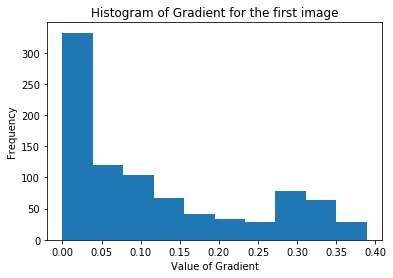

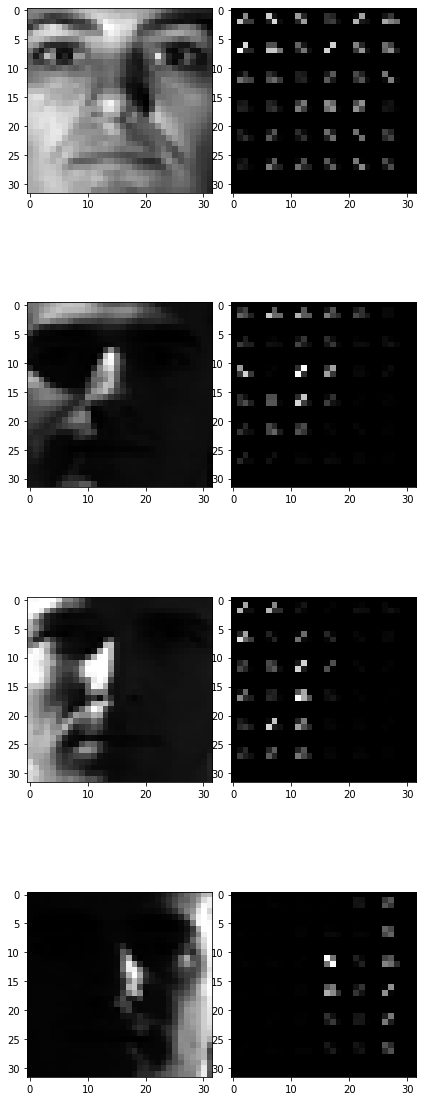

In [26]:
from skimage import exposure

# Histogram for first image
plt.hist(hog_train[0])
plt.title("Histogram of Gradient for the first image")
plt.ylabel("Frequency")
plt.xlabel("Value of Gradient")
plt.show()

# Plot first four image
image, _ = next(iter(train_loader))
for i in range(len(image)):
    plt.subplot(4,2,2*i+1)
    plt.imshow(image[i].squeeze().numpy(), cmap='gray')
    hog_image_rescale = exposure.rescale_intensity(hog_images_train[i], in_range=(0, 100))
    plt.subplot(4,2,2*i+2)
    plt.imshow(hog_image_rescale, cmap='gray')
plt.subplots_adjust(left=0,top=4, bottom=0, hspace=0.1, wspace=0.1)

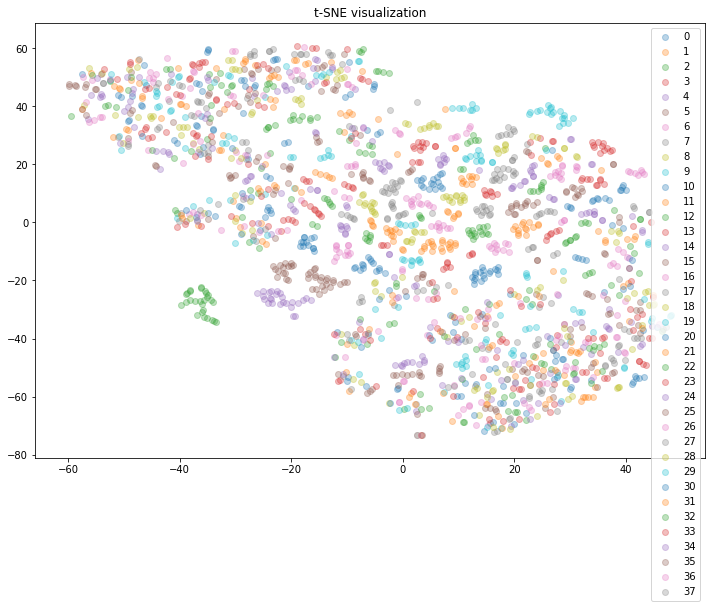

In [27]:
# visualize t-SNE
visualize_tsne(X_train['hog'], y_train)

### 2). Classifiers

We will use two simple classifiers to evaluate different feature extractions. The two classifiers are k-Nearest Neighbors (k-NN) and Support Vector Machine (SVM). For both of the two classifiers, we use Grid Search to tune the hyperparamters.

As stated above, we will use original pixel values without any feature extraction applied as part of our baselines, we name it as "Plain".

In [28]:
# directly using original pixel features without any feature extraction applied
train_loader_flat = td.DataLoader(train_set_flat, batch_size=train_set_flat.__len__(), shuffle=False)
test_loader_flat = td.DataLoader(test_set_flat, batch_size=test_set_flat.__len__(), shuffle=False)

for _, (x_train_org, y_train_org) in enumerate(train_loader_flat):
    x_train_org = x_train_org.squeeze().numpy()
    X_train['origin'] = x_train_org

for _, (x_test_org, y_test_org) in enumerate(test_loader_flat):
    x_test_org = x_test_org.squeeze().numpy()
    X_test['origin'] = x_test_org

#### a). k-Nearest Neighbors (k-NN)

k-Nearest Neighbors (k-NN) works by calculating the distances between a query and all examples in the training data, selecting the k-closest samples to the query, then voteing for the most frequent label (in the case of classification) or averages the labels (in the case of regression). A test sample will be classified by a plurality vote of its neighbors, with the sample being assigned to the class most common among its k nearest neighbors.

In [29]:
# evaluations
acc_train_knn = []
acc_test_knn = []

for k in X_train.keys():
    if k == 'origin':
        print("Train with original image:")
    else:
        print("Train with %s features:" % k)
    model_knn = train_knn(X_train[k], y_train)
    save_model(model_knn, "models/knn_%s.pth" % k)
    y_train_pred = model_knn.predict(X_train[k])
    y_test_pred = model_knn.predict(X_test[k])
    acc_train_knn.append(np.mean(y_train_pred == y_train))
    acc_test_knn.append(np.mean(y_test_pred == y_test))
    print("Accuracy on train set: %f" % np.mean(y_train_pred == y_train))
    print("Accuracy on test set: %f" % np.mean(y_test_pred == y_test))
    print("\n")

Train with pca features:
Best parameters: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Model saved to models/knn_pca.pth.
Accuracy on train set: 1.000000
Accuracy on test set: 0.757764


Train with lda features:
Best parameters: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Model saved to models/knn_lda.pth.
Accuracy on train set: 1.000000
Accuracy on test set: 0.933747


Train with ica features:
Best parameters: {'n_neighbors': 3, 'p': 2, 'weights': 'distance'}
Model saved to models/knn_ica.pth.
Accuracy on train set: 1.000000
Accuracy on test set: 0.908903


Train with lbp features:
Best parameters: {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
Model saved to models/knn_lbp.pth.
Accuracy on train set: 1.000000
Accuracy on test set: 0.904762


Train with hog features:
Best parameters: {'n_neighbors': 10, 'p': 1, 'weights': 'distance'}
Model saved to models/knn_hog.pth.
Accuracy on train set: 1.000000
Accuracy on test set: 0.857143


Train with original image:
Best paramet

#### b). Support Vector Machine (SVM)

For SVM, we are not going to elabrate its ideas since it is already introduced well in class. The only thing we want to mention is that we apply RBF kernels here for SVM.

In [30]:
# evaluations
acc_train_svm = []
acc_test_svm = []

# initialize SVM agent
svm_agent = SVM_agent()

for k in X_train.keys():
    if k == 'origin':
        print("Train with original image:")
    else:
        print("Train with %s features:" % k)
    svm_agent.reset()
    svm_agent.hyper_tune(X_train[k], y_train)
    save_model(svm_agent.agent, "models/svm_%s.pth" % k)
    eval_train = svm_agent.test(X_train[k], y_train)
    eval_test = svm_agent.test(X_test[k], y_test)
    acc_train_svm.append(eval_train)
    acc_test_svm.append(eval_test)
    print("Accuracy on train set: %f" % eval_train)
    print("Accuracy on test set: %f" % eval_test)
    print("\n")

Train with pca features:
Best parameters: {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
Model saved to models/svm_pca.pth.
Accuracy on train set: 0.986018
Accuracy on test set: 0.931677


Train with lda features:
Best parameters: {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
Model saved to models/svm_lda.pth.
Accuracy on train set: 0.994821
Accuracy on test set: 0.931677


Train with ica features:
Best parameters: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Model saved to models/svm_ica.pth.
Accuracy on train set: 0.990678
Accuracy on test set: 0.937888


Train with lbp features:
Best parameters: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Model saved to models/svm_lbp.pth.
Accuracy on train set: 1.000000
Accuracy on test set: 0.933747


Train with hog features:
Best parameters: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Model saved to models/svm_hog.pth.
Accuracy on train set: 1.000000
Accuracy on test set: 0.971014


Train with original image:
Best parameters: {'C': 1000, 'gamma': 0.0001, 'kernel'

## Results

**Comparative Study using different Feature Extractions & Classifiers:**

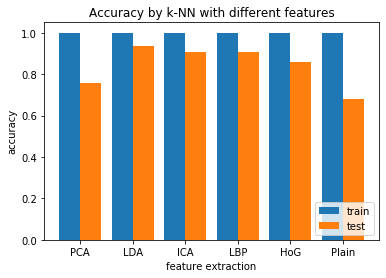

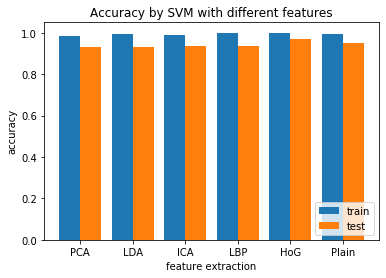

In [31]:
# plot
labels = ['PCA', 'LDA', 'ICA', 'LBP', 'HoG', 'Plain']

plt.figure()
plt.title("Accuracy by k-NN with different features")
plt.bar(np.arange(len(acc_train_knn))-0.2, acc_train_knn, width=0.4, label="train")
plt.bar(np.arange(len(acc_test_knn))+0.2, acc_test_knn, width=0.4, label="test")
plt.xticks(np.arange(len(acc_test_knn)), labels)
plt.xlabel("feature extraction")
plt.ylabel("accuracy")
plt.legend(loc=4)
plt.show()

plt.figure()
plt.title("Accuracy by SVM with different features")
plt.bar(np.arange(len(acc_train_svm))-0.2, acc_train_svm, width=0.4, label="train")
plt.bar(np.arange(len(acc_test_svm))+0.2, acc_test_svm, width=0.4, label="test")
plt.xticks(np.arange(len(acc_test_svm)), labels)
plt.xlabel("feature extraction")
plt.ylabel("accuracy")
plt.legend(loc=4)
plt.show()

##### **KNN** Model: Best Parameters and Accuracy.                            

|  Table 1      | PCA |LDA| ICA|LBP|HoG | Plain(<font color="#0000dd">*Baseline*</font>)
| :---        |    :----:   |          ---: |           ---: |           ---: |          ---: |          ---: |
| n-neighbors    |     3        |           3    |    3 |           5                |            10    |    3         |          
| **Accuracy**     |    0.757         |    0.933           |  0.908   |          0.905    |      0.857          |     0.681        |

##### **SVM** Model: Best Parameters and Accuracy

|   Table 2     | PCA |LDA| ICA|LBP|HoG | Plain
| :---        |    :----:   |          ---: |           ---: |           ---: |          ---: |          ---: |
| C-value    |     1000        |           1    |   10 |           10               |            100    |    1000         |          
| kernel type     |    rbf         |    rbf           |  rbf   | rbf          |              rbf |     rbf        |
| gamma-value    |     0.0001        |           0.001    |   1 |           1              |            0.01    |    0.0001         | 
| **Accuracy**    |     0.931        |           0.931    |   0.938 |           0.934            |           0.971    |    0.948        | 

After we trained our model with the image data, we conducted comparative study using the pairs of different feature extraction and classification methods. The bar plots and the tables above show the result of our comparisons.

Our baseline case plain k-NN(k-NN model without any feature extraction) has **0.681** accuracy on the test dataset. And our test cases with other model setups all achieve better test accuracy($\geq$ **0.757**) than the baseline case. This result indicates the effectiveness of the models we select and implement.

For the classification methods, we can see from the tables that the overall performance of SVM is better than the performance of KNN model. And for the feature extraction methods, the best method for k-NN classifier is Linear Discriminant Analysis (LDA), which obtains 0.933 test accuracy. For SVM classifier, the most suitable methods is Histogram of Gradient (HoG), it achieves 0.971 test acurracy.

**What about these results surprised you?**
1. The k-NN classifier can achieve high test accuracy ($\geq$0.9) with feature extractions. k-Nearest Neighbors(k-NN) is almost the easiest model among the popular supervised models. The idea behind this method is straightforward (without training process and parameter updates). So for problems with large feature numbers, like facial recognition, k-NN model often has terrible performance. But after we applied our feature extraction models(LDA, ICA, LBP), the test accuracy of k-NN is boosted from **0.681** to **0.9**. This shows that our feature extractions are feasible and effective for this facial recognition problem. 

2. The SVM classifier with plain images performs better than some feature-extracted cases. SVM without feature extractions obtains 0.948 accuracy on test dataset, which is a little higher than some cases with feature extraction(e.g. ICA). This result is actually reasonable. SVM is already a powerful model for medium-scale classification tasks, thus with more feature inputs(like plain images), SVM may be able to make better decisions on the classifications than the ones with extracted feature inputs.

**What do these plots show about over- or under-fitting?**

There is no obvious under-fitting in our current results. But for over-fitting, in our bar plots, it can be identified when the accurary on training set is much higher than the test acurracy (blue bar is much higher than the orange bar). We can see k-NN method tends to over-fit the training dataset. It is the property of k-NN model, when n_neighbor (k-value) is set to small value (e.g.one neighbor), k-NN model is likely to over-fit the training data. This issue can be addressed by slightly increasing the n_neighbor value (but large n_neighbor may decrease overall the accuracy).

For SVM model, we solve the possible over-fitting issue by tuning the regularization parameter(C-value) and RBF kernel parameter(gamma-value). Table 1 and Table 2 also include the results of our hyperparameter-tuning.

**What does the evaluation of your models tell you about your data? How do you expect these models might behave differently on different data?**

In our results, even k-NN method with the original pixel feature inputs acquires the acceptable test accuracy. This implies that the majority of our facial images are collected from the same camera angle and viewpoints. If the facial images inputs are generated from different angles and viewpoints (e.g. use flip&rotation), then performance of k-NN would become worse. How to deal with this angle problem is one of the topics of our future study.

#### ResNet18 as classifier:

Epoch: 10 | Train Loss: 0.300 | Train Acc: 91.77% | Test Loss: 0.735 | Test Acc: 83.23%
Epoch: 20 | Train Loss: 0.173 | Train Acc: 95.13% | Test Loss: 0.648 | Test Acc: 84.47%
Epoch: 30 | Train Loss: 0.042 | Train Acc: 98.86% | Test Loss: 0.346 | Test Acc: 91.93%
Epoch: 40 | Train Loss: 0.018 | Train Acc: 99.53% | Test Loss: 0.325 | Test Acc: 92.13%
Epoch: 50 | Train Loss: 0.015 | Train Acc: 99.59% | Test Loss: 0.309 | Test Acc: 92.96%
Epoch: 60 | Train Loss: 0.013 | Train Acc: 99.69% | Test Loss: 0.276 | Test Acc: 92.34%
Epoch: 70 | Train Loss: 0.011 | Train Acc: 99.69% | Test Loss: 0.297 | Test Acc: 92.34%
Epoch: 80 | Train Loss: 0.008 | Train Acc: 99.74% | Test Loss: 0.295 | Test Acc: 92.13%
Epoch: 90 | Train Loss: 0.008 | Train Acc: 99.84% | Test Loss: 0.278 | Test Acc: 92.55%
Epoch: 100 | Train Loss: 0.008 | Train Acc: 99.95% | Test Loss: 0.273 | Test Acc: 92.75%


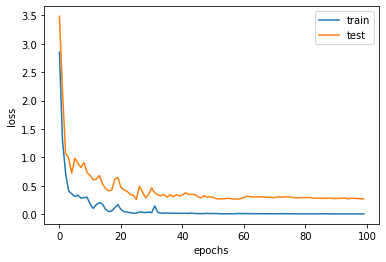

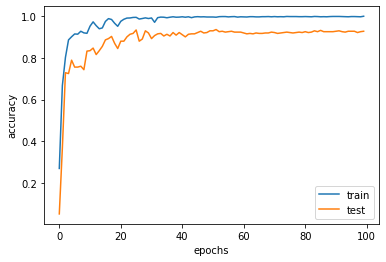

Model saved to models/resnet.pth.


In [32]:
# train ResNet18
model_resnet = train_resnet(train_set, test_set)

# save and reload model
save_model(model_resnet, "models/resnet.pth")
model_resnet = load_model("models/resnet.pth")

In order to explore more feasible methods and provide more comparison baselines, we tried a neural network model ResNet on our facial recognition task. The learning result of this CNN-based method is pretty satisfying. After the training of 100 epochs, ResNet model gets **0.927** accuracy on the test dataset. 

But if we compare the performance of ResNet with our previous results, we can see that some simpler classifiers with feature extractions surpass this ResNet model on our dataset. For example, SVM classifier with HoG achieves **0.971** test accuracy, while ResNet only gets **0.927** on the test dataset.

# Discussions

In our project, we proposed and realized ML solutions for a facial recognition problem. 
To accomplish this multi-class classification task, we adopted some ML models that are covered by our lectures(e.g PCA, SVM, CNN), and also got to learn about several useful feature extraction techniques which were not introduced in class. We implemented our models and validated the effectiveness through some comparative experiments on the image data.

**What aspects of your project did you find most surprising?**

1. Feature extraction methods can tremendously improve the performance of k-NN model on our dataset. k-NN model directly assigns objects to class based on the feature distance. Thus it is actually reasonable that k-NN model can make better classification decisions when extracted features are more representative.

2. Surprisingly, with appropriate feature extraction, simple classifier can even outperform the complex ResNet model which is presumably to be the best among our selected classifiers both in terms of the accuracy and efficiency. This further verifed the effectiveness of the feature extraction on our task.

**What lessons did you take from this project that you want to remember for the next ML project you work on?**

The first lesson we take from our project is the significance of feature extraction. We learned several feature extraction models and practiced the methods on real datasets. Our experiments demonstrate that feature extraction can effectively promote the classifier performance on the problems with large feature numbers. Also a convincing implementation of feature extraction may provide more insights into the problem and increase the interpretability of ML models. 

Another thing we learn from our project is about the deep neural networks model. Our results show that DNN might not promise to be the universially best choice for image recognition tasks. It may be prone to overfitting and the optimization could be slow. If we can use feature extractions flexibly and appropriately, simple classifier can also achieve great performance with much less time-consumption.

**What was the most helpful feedback you received during your presentation?**

The feedback from Frederick Xu's group is very helpful. They suggest us to perform data augmentation with these images, for example rotate the image, or cropped the faces, etc. This is a valuable feedback. Our current image data are all collected from the similar viewpoints and illuminations, both KNN and SVM classifier can finally get good accuracy. But when the viewpoint changes, the classifier performance may deteriorate. So data augmentation could be helpful to make trained classifier more powerful if we further would like to apply our models on more challenging cases. 

**If you had two more weeks to work on this project, what would you do next?**
1. First we will try data augmentation on our data. Training with augmented images could make our classifier more adaptive and robust.
2. Second we can conduct the LIME analysis on our classification and feature extraction results. It may help us to better interpret in detail how the feature extraction improves the classifier performance. This can enhance our understanding about the feature extraction methods.